In [1]:
import networkx as nx
from networkx.algorithms.community import kernighan_lin_bisection
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Qubit
import numpy as np
from scipy.sparse import csr_matrix


from graph_embedding.dmon.train import *

# Sandbox

In [2]:
def evaluate_partition(graph, partitions):
    conductance = nx.algorithms.cuts.conductance(graph, partitions[0].nodes)
    modularity = nx.algorithms.community.modularity(graph, [part.nodes for part in partitions])
    # Telecommunication cost (example, needs more detailed implementation)
    tele_cost = sum(graph.edges[edge]['weight'] for edge in graph.edges if edge[0] in partitions[0] and edge[1] in partitions[1])
    return conductance, modularity, tele_cost

In [3]:

# Evaluate the partitions
conductance, modularity, tele_cost = evaluate_partition(graph, partitions)

print(f"Conductance: {conductance}")
print(f"Modularity: {modularity}")
print(f"Telecommunication Cost: {tele_cost}")

NameError: name 'graph' is not defined

In [2]:
import networkx as nx
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap

# Define the architecture
architecture = nx.Graph()
# QPU1 connections (fully connected)
architecture.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])
# QPU2 connections (fully connected)
architecture.add_edges_from([(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)])
# Inter-QPU connection
architecture.add_edge(2, 6)


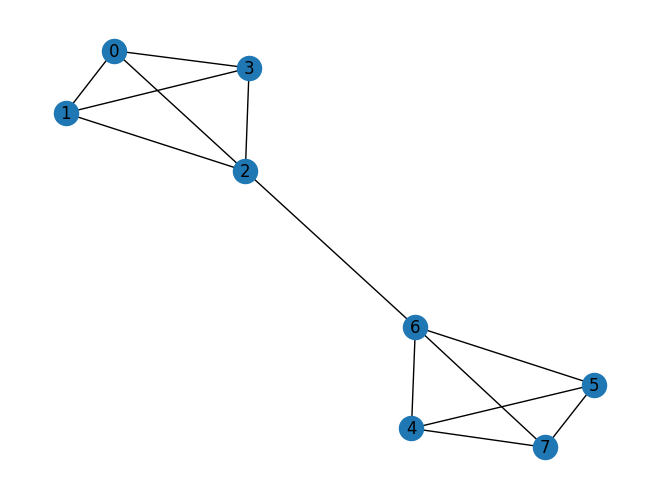

In [3]:
# Draw achitecture
nx.draw(architecture, with_labels=True)

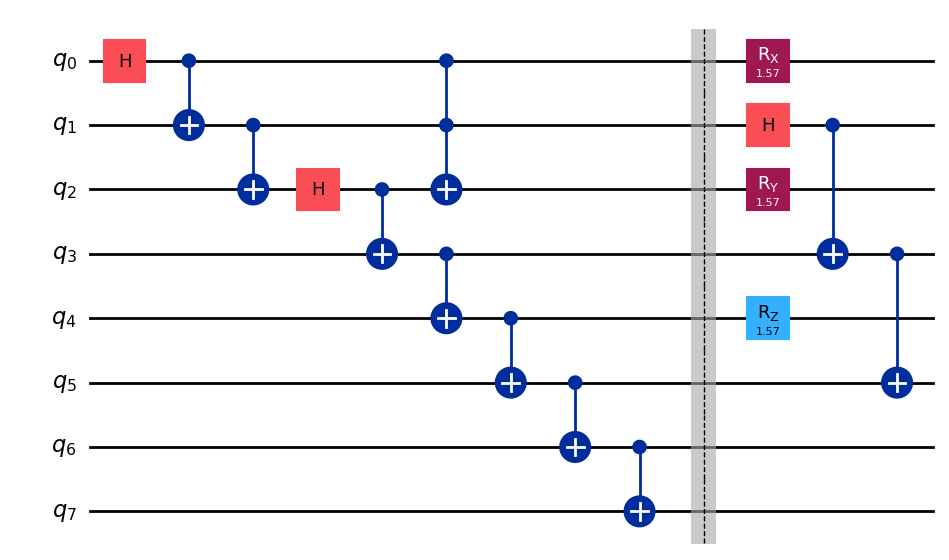

In [22]:
# Create a complex quantum circuit
qc = QuantumCircuit(8)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.h(2)
qc.cx(2, 3)
qc.cx(3, 4)
qc.cx(4, 5)
qc.cx(5, 6)
qc.cx(6, 7)
qc.ccx(0, 1, 2)
qc.barrier()
qc.h(1)
qc.cx(1, 3)
qc.cx(3, 5)
qc.rx(1.57, 0)
qc.ry(1.57, 2)
qc.rz(1.57, 4)

qc.draw('mpl')

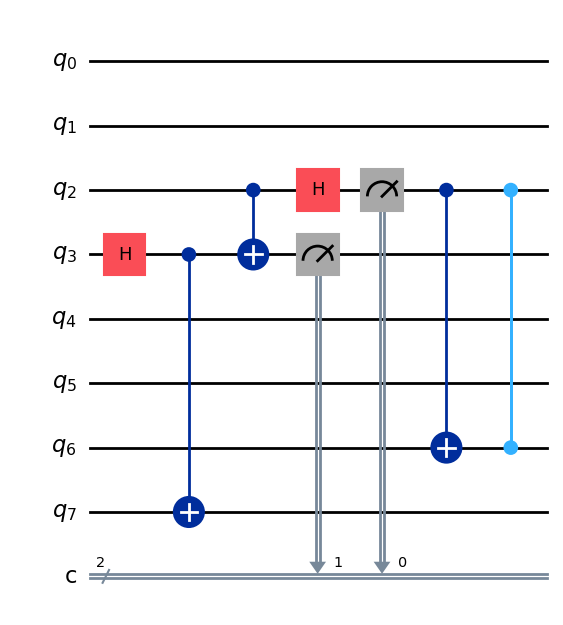

In [16]:
from qiskit import QuantumCircuit

def create_entanglement(circuit, q1, q2):
    """
    Create an EPR pair between qubit q1 (in QPU1) and qubit q2 (in QPU2).
    """
    circuit.h(q1)
    circuit.cx(q1, q2)

def telegate_cnot(circuit, q1_control, q1_ancilla, q2_target, q2_ancilla):
    """
    Perform a CNOT gate between q1_control in QPU1 and q2_target in QPU2 using telegate.
    q1_ancilla and q2_ancilla are ancilla qubits used for the telegate process.
    """
    # Step 1: Create entanglement between ancilla qubits
    create_entanglement(circuit, q1_ancilla, q2_ancilla)
    
    # Step 2: Perform local operations
    circuit.cx(q1_control, q1_ancilla)
    circuit.h(q1_control)
    
    # Step 3: Measure and communicate results
    circuit.measure(q1_control, 0)
    circuit.measure(q1_ancilla, 1)
    
    # Step 4: Conditional operations based on measurement results
    circuit.cx(q1_control, q2_target)
    circuit.cz(q1_control, q2_target)

# Create a quantum circuit with 8 qubits and 2 classical bits
qc = QuantumCircuit(8, 2)

# Example: Perform telegate CNOT between qubit 2 (QPU1) and qubit 6 (QPU2)
telegate_cnot(qc, q1_control=2, q1_ancilla=3, q2_target=6, q2_ancilla=7)

# Draw the circuit
qc.draw('mpl')


In [5]:

# Function to add teleportation between qubits q1 and q2
def add_teleportation(circuit, q1, q2):
    circuit.h(q1)
    circuit.cx(q1, q1 + 1)
    circuit.cx(q2, q1 + 1)
    circuit.h(q2)
    circuit.measure(q2, 0)
    circuit.measure(q1 + 1, 1)
    circuit.cx(q1, q2)
    circuit.cz(q1, q2)

In [6]:
qc2 = QuantumCircuit(8,2)
add_teleportation(qc2, 2, 6)

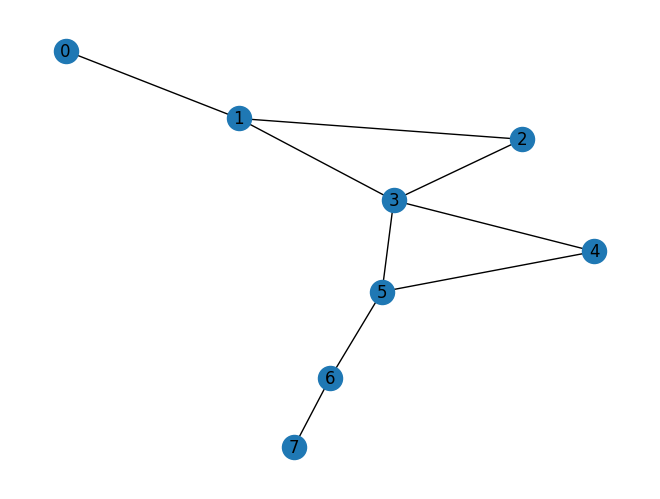

In [15]:
# Convert the circuit to a graph
def circuit_to_graph(circuit):
    graph = nx.Graph()
    qubit_indices = {qubit: idx for idx, qubit in enumerate(circuit.qubits)}
    
    for gate in circuit.data:
        if len(gate[1]) == 2:  # two-qubit gates
            q1, q2 = gate[1]
            idx1, idx2 = qubit_indices[q1], qubit_indices[q2]
            if graph.has_edge(idx1, idx2):
                graph[idx1][idx2]['weight'] += 1
            else:
                graph.add_edge(idx1, idx2, weight=1)
        elif len(gate[1]) == 1:  # single-qubit gates
            q = gate[1][0]
            idx = qubit_indices[q]
            if not graph.has_node(idx):
                graph.add_node(idx)
    
    return graph

graph = circuit_to_graph(qc)

# Draw the graph
nx.draw(graph, with_labels=True)

[4, 5, 6, 7]
[0, 1, 2, 3]


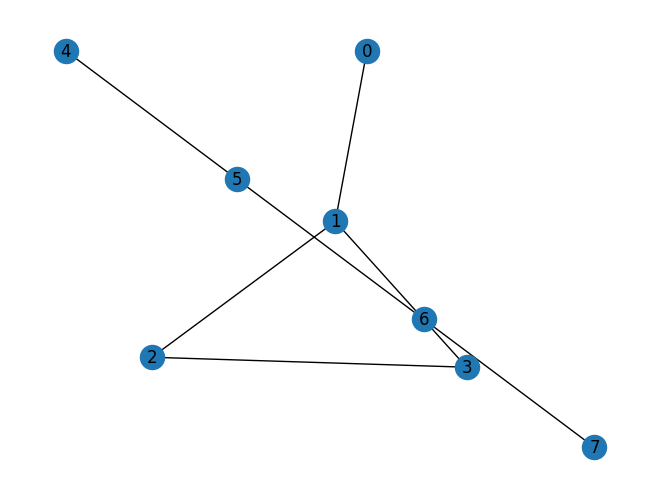

In [16]:
def partition_graph(graph, k):
    partitions = [graph]
    while len(partitions) < k:
        new_partitions = []
        for part in partitions:
            nodes1, nodes2 = kernighan_lin_bisection(part)
            subgraph1 = graph.subgraph(nodes1).copy()
            subgraph2 = graph.subgraph(nodes2).copy()
            new_partitions.extend([subgraph1, subgraph2])
        partitions = new_partitions
    return partitions

partitions = partition_graph(graph, 2)

# Draw the partitions
for part in partitions:
    nx.draw(part, with_labels=True)
    print(part.nodes)

In [19]:
# Partition the circuit (qubits 0-3 in QPU1, qubits 4-7 in QPU2)
partition1 = partitions[0].nodes
partition2 = partitions[1].nodes

# Create new circuits for each partition
partitioned_qc1 = QuantumCircuit(4, 2)  # 4 qubits in QPU1, 2 classical bits for teleportation
partitioned_qc2 = QuantumCircuit(4, 2)  # 4 qubits in QPU2, 2 classical bits for teleportation

def map_gate_to_partition(circuits, partition1, partition2, partitioned_qc1, partitioned_qc2):
    for gate in circuits.data:
        if len(gate[1]) == 2:  # two-qubit gates
            q1, q2 = gate[1]
            # if (circuits.find_bit(q1)[0] in partition1 and circuits.find_bit(q2)[0] in partition2) or (circuits.find_bit(q1)[0] in partition2 and circuits.find_bit(q2)[0]in partition1):
                # Inter-QPU gate, add teleportation
                # add_teleportation(partitioned_qc1, 2, 6)  # qubit 2 in QPU1 to qubit 6 in QPU2
            if circuits.find_bit(q1)[0] in partition1:
            # elif circuits.find_bit(q1)[0] in partition1:
                partitioned_qc1.append(gate[0], [partitioned_qc1.qubits[circuits.find_bit(q1)[0] - 4], partitioned_qc1.qubits[circuits.find_bit(q2)[0] - 4]])
                # print(gate[0], [circuits.find_bit(q1)[0], circuits.find_bit(q2)[0]])
            else:
                partitioned_qc2.append(gate[0], [partitioned_qc2.qubits[circuits.find_bit(q1)[0] - 4], partitioned_qc2.qubits[circuits.find_bit(q2)[0] - 4]])
        elif len(gate[1]) == 1:  # single-qubit gates
            q = gate[1][0]
            if circuits.find_bit(q)[0] in partition1:
                partitioned_qc1.append(gate[0], [partitioned_qc1.qubits[circuits.find_bit(q)[0] -4 ]])
                # print(gate[0], [circuits.find_bit(q)[0]])
            else:
                partitioned_qc2.append(gate[0], [partitioned_qc2.qubits[circuits.find_bit(q)[0] - 4]])

# Map gates to partitions
map_gate_to_partition(qc, partition1, partition2, partitioned_qc1, partitioned_qc2)

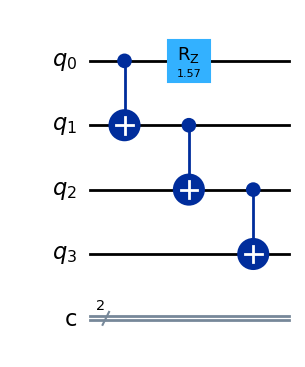

In [20]:
partitioned_qc1.draw('mpl')

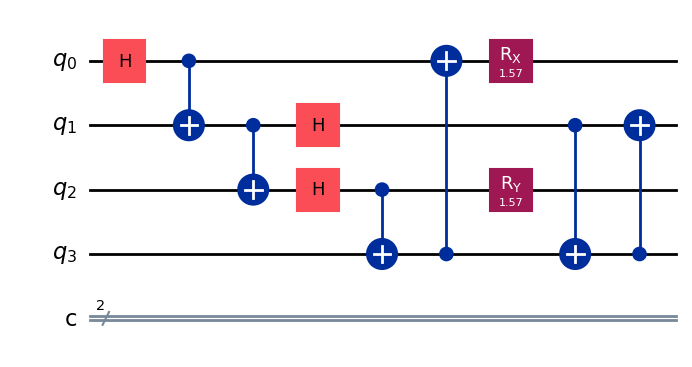

In [21]:
partitioned_qc2.draw('mpl')

In [27]:

# Create a new circuit for each partition
def partition_to_circuit(partitions, original_circuit):
    circuits = [QuantumCircuit(len(part)) for part in partitions]
    qubit_map = {qubit: idx for idx, qubit in enumerate(original_circuit.qubits)}
    
    for gate in original_circuit.data:
        if len(gate[1]) == 2:  # two-qubit gates
            q1, q2 = gate[1]
            idx1, idx2 = qubit_map[q1], qubit_map[q2]
            for i, part in enumerate(partitions):
                new_qubits = (Qubit(circuits[i].qregs[0], 0), Qubit(circuits[i].qregs[0], 1))
                new_gate = gate.replace(qubits=new_qubits)
                if idx1 in part and idx2 in part:
                    circuits[i].append(new_gate)
                    break
        elif len(gate[1]) == 1:  # single-qubit gates
            q = gate[1][0]
            idx = qubit_map[q]
            for i, part in enumerate(partitions):
                if idx in part:
                    circuits[i].append(gate.replace(qubits=circuits[i].qregs))
                    break

    return circuits

partitioned_circuits = partition_to_circuit(partitions, qc)

# Draw the partitioned circuits
for circ in partitioned_circuits:
    print(circ)
    circ.draw()

     ┌───┐             ┌───┐                ┌───┐     ┌──────────┐┌──────────┐
q_0: ┤ H ├──■────■─────┤ H ├─────────■──────┤ H ├──■──┤ Rx(1.57) ├┤ Ry(1.57) ├
     ├───┤┌─┴─┐┌─┴─┐   ├───┤       ┌─┴─┐    ├───┤┌─┴─┐├──────────┤├──────────┤
q_1: ┤ H ├┤ X ├┤ X ├───┤ H ├───────┤ X ├────┤ H ├┤ X ├┤ Rx(1.57) ├┤ Ry(1.57) ├
     ├───┤├───┤├───┤┌──┴───┴───┐┌──┴───┴───┐└───┘└───┘└──────────┘└──────────┘
q_2: ┤ H ├┤ H ├┤ H ├┤ Rx(1.57) ├┤ Ry(1.57) ├──────────────────────────────────
     ├───┤├───┤├───┤├──────────┤├──────────┤                                  
q_3: ┤ H ├┤ H ├┤ H ├┤ Rx(1.57) ├┤ Ry(1.57) ├──────────────────────────────────
     └───┘└───┘└───┘└──────────┘└──────────┘                                  
                           ┌──────────┐
q_0: ─────■────────■────■──┤ Rz(1.57) ├
        ┌─┴─┐    ┌─┴─┐┌─┴─┐├──────────┤
q_1: ───┤ X ├────┤ X ├┤ X ├┤ Rz(1.57) ├
     ┌──┴───┴───┐└───┘└───┘└──────────┘
q_2: ┤ Rz(1.57) ├──────────────────────
     ├──────────┤                      
q_3: ┤ Rz

In [31]:

# Define the coupling maps for the QPUs
coupling_map_qpu1 = CouplingMap([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])
coupling_map_qpu2 = CouplingMap([(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)])

# Transpile the circuits for each QPU
transpiled_circuits = []
for i, partitioned_circuit in enumerate(partitioned_circuits):
    if i == 0:
        transpiled_circuits.append(transpile(partitioned_circuit, coupling_map=coupling_map_qpu1))
    else:
        transpiled_circuits.append(transpile(partitioned_circuit, coupling_map=coupling_map_qpu2))

# Draw the transpiled circuits
for i, circuit in enumerate(transpiled_circuits):
    print(f"Transpiled circuit for QPU {i+1}:")
    display(circuit.draw())


Transpiled circuit for QPU 1:


global phase: 6.2824
                                 ┌───┐     ┌─────────────────────────────┐
q_0 -> 0 ───────────■────────────┤ H ├──■──┤ U3(1.5708,-1.57,0.00079633) ├
                  ┌─┴─┐          ├───┤┌─┴─┐├─────────────────────────────┤
q_1 -> 1 ─────────┤ X ├──────────┤ H ├┤ X ├┤ U3(1.5708,-1.57,0.00079633) ├
         ┌────────┴───┴─────────┐└───┘└───┘└─────────────────────────────┘
q_2 -> 2 ┤ U3(3.1408,0,-1.5716) ├─────────────────────────────────────────
         ├──────────────────────┤                                         
q_3 -> 3 ┤ U3(3.1408,0,-1.5716) ├─────────────────────────────────────────
         └──────────────────────┘

Transpiled circuit for QPU 2:


┌──────────┐            
      q_2 -> 0 ┤ Rz(1.57) ├────────────
               ├──────────┤            
      q_3 -> 1 ┤ Rz(1.57) ├────────────
               └──────────┘            
ancilla_0 -> 2 ────────────────────────
                                       
ancilla_1 -> 3 ────────────────────────
                           ┌──────────┐
      q_0 -> 4 ─────■──────┤ Rz(1.57) ├
                  ┌─┴─┐    ├──────────┤
      q_1 -> 5 ───┤ X ├────┤ Rz(1.57) ├
                  └───┘    └──────────┘
ancilla_2 -> 6 ────────────────────────
                                       
ancilla_3 -> 7 ────────────────────────

In [10]:
from qiskit import QuantumCircuit

def create_entanglement(circuit, q1, q2):
    """
    Create an EPR pair between qubit q1 (in QPU1) and qubit q2 (in QPU2).
    """
    circuit.h(q1)
    circuit.cx(q1, q2)

def add_teleportation(circuit, q1, q2, classical_registers):
    """
    Adds quantum teleportation to the circuit to teleport the state of qubit q1 to qubit q2.
    
    Parameters:
    - circuit: QuantumCircuit object to which teleportation is added
    - q1: index of the qubit in QPU1 (sender)
    - q2: index of the qubit in QPU2 (receiver)
    - classical_registers: List of classical registers to store measurement results
    """
    # Step 1: Create entanglement
    create_entanglement(circuit, q1, q2)
    
    # Step 2: Bell state measurement
    circuit.cx(q1, q1 + 1)
    circuit.h(q1)
    
    # Step 3: Measure and communicate results
    circuit.measure(q1, classical_registers[0])
    circuit.measure(q1 + 1, classical_registers[1])
    
    # Step 4: Conditional operations based on measurement results
    circuit.cx(q1, q2)
    circuit.cz(q1, q2)

# Define the partitioned subcircuits
subcircuit1 = QuantumCircuit(4, 2)  # 4 qubits in QPU1, 2 classical bits for teleportation
subcircuit2 = QuantumCircuit(4, 2)  # 4 qubits in QPU2, 2 classical bits for teleportation

# Add operations to the subcircuits
subcircuit1.h(0)
subcircuit1.cx(0, 1)
subcircuit1.cx(1, 2)
subcircuit1.h(2)
subcircuit1.cx(2, 3)

subcircuit2.cx(0, 1)
subcircuit2.cx(1, 2)
subcircuit2.cx(2, 3)
subcircuit2.ccx(0, 1, 2)

# Define the combined circuit
combined_circuit = QuantumCircuit(8, 4)  # 8 qubits in total, 4 classical bits for teleportation


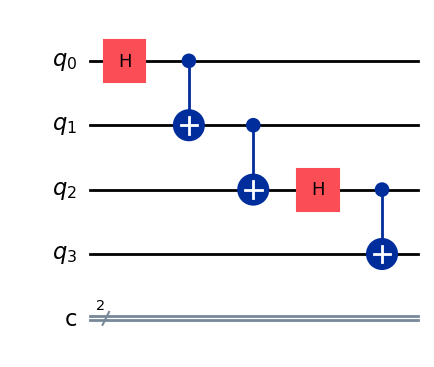

In [11]:
subcircuit1.draw('mpl')

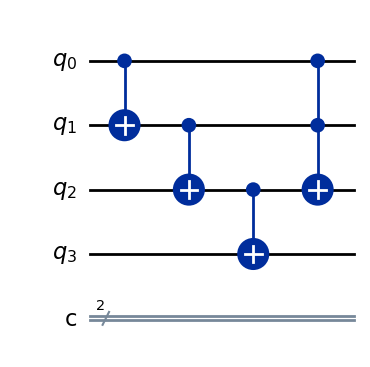

In [12]:
subcircuit2.draw('mpl')

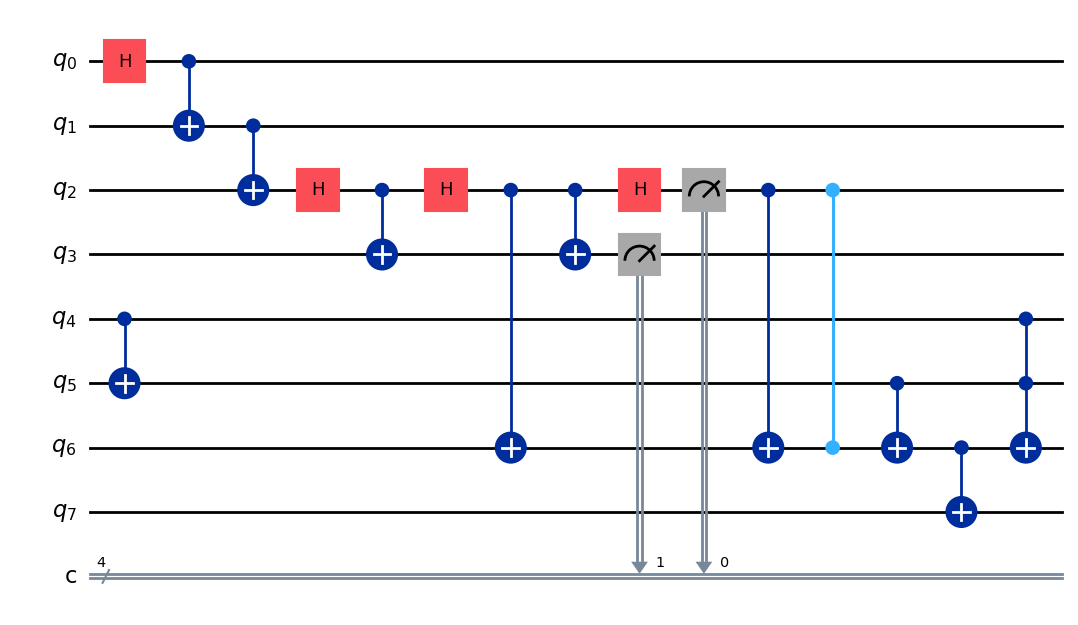

In [13]:

# Add subcircuit1 to the combined circuit
for gate in subcircuit1.data:
    combined_circuit.append(gate[0], [combined_circuit.qubits[subcircuit1.find_bit(q)[0]] for q in gate[1]], gate[2])

# Add teleportation between qubit 2 (QPU1) and qubit 6 (QPU2)
add_teleportation(combined_circuit, q1=2, q2=6, classical_registers=[0, 1])

# Add subcircuit2 to the combined circuit
for gate in subcircuit2.data:
    combined_circuit.append(gate[0], [combined_circuit.qubits[subcircuit2.find_bit(q)[0] + 4] for q in gate[1]], gate[2])

# Draw the final combined circuit
combined_circuit.draw('mpl')


# Experiments start here

In [2]:
def generate_random_circuit(num_qubits, depth):
    qc = QuantumCircuit(num_qubits)
    for _ in range(depth):
        qubit1 = np.random.randint(0, num_qubits)
        qubit2 = np.random.randint(0, num_qubits)
        if qubit1 != qubit2:
            qc.cx(qubit1, qubit2)
        else:
            qc.h(qubit1)
    return qc

def adjust_weights_based_on_hardware(graph, hardware_graph):
    for (u, v) in graph.edges():
        if hardware_graph.has_edge(u, v):
            graph[u][v]['weight'] *= 0.5  # Lower weight for edges within the same QPU
        else:
            graph[u][v]['weight'] *= 2.0  # Higher weight for inter-QPU edges
    return graph

def circuit_to_graph(circuit, hardware_graph=None):
    graph = nx.Graph()
    qubit_indices = {qubit: idx for idx, qubit in enumerate(circuit.qubits)}
    
    for gate in circuit.data:
        if len(gate[1]) == 2:  # Two-qubit gates
            q1, q2 = gate[1]
            idx1, idx2 = qubit_indices[q1], qubit_indices[q2]
            if graph.has_edge(idx1, idx2):
                graph[idx1][idx2]['weight'] += 1
            else:
                graph.add_edge(idx1, idx2, weight=1)
        elif len(gate[1]) == 1:  # Single-qubit gates
            q = gate[1][0]
            idx = qubit_indices[q]
            if not graph.has_node(idx):
                graph.add_node(idx)
    
    if hardware_graph:
        graph = adjust_weights_based_on_hardware(graph, hardware_graph)
    
    return graph

def partition_graph(circuit, hardware_graph, method='KL'):
    graph = circuit_to_graph(circuit, hardware_graph)
    num_qubits = circuit.num_qubits
    if method == 'KL':
        nodes1, nodes2 = kernighan_lin_bisection(graph)
        
        # Map the nodes to hardware graph nodes
        hw_nodes1, hw_nodes2 = set(), set()
        for node in nodes1:
            if node in hardware_graph:
                hw_nodes1.add(node)
        for node in nodes2:
            if node in hardware_graph:
                hw_nodes2.add(node)

        # Add inter-QPU edges based on hardware connectivity
        inter_qpu_edges = [(u, v) for u in hw_nodes1 for v in hw_nodes2 if hardware_graph.has_edge(u, v)]
        
        partitioned_graph = [graph.subgraph(nodes1).copy(), graph.subgraph(nodes2).copy()]
    # Placeholder for other methods (GA, GNN)
    # elif method == 'GA':
    #     partitioned_graph, inter_qpu_edges = genetic_algorithm_partitioning(graph, hardware_graph)
    elif method == 'GNN':
        adj_matrix = graph_to_sparse_adjacency_matrix(graph, num_qubits)
    #     partitioned_graph, inter_qpu_edges = gnn_partitioning(graph, hardware_graph)

    return partitioned_graph, inter_qpu_edges

def graph_to_sparse_adjacency_matrix(graph, num_qubits):
    # Initialize lists to store the data, row indices, and column indices
    data = []
    row_indices = []
    col_indices = []
    
    
    # Iterate over each edge in the graph
    for u, v, edge_data in graph.edges(data=True):
        weight = edge_data['weight'] if 'weight' in edge_data else 1  # Default weight to 1 if not specified
        data.append(weight)
        row_indices.append(u)
        col_indices.append(v)
        
        if u != v:  # Ensure we don't duplicate self-loops
            data.append(weight)
            row_indices.append(v)
            col_indices.append(u)
    
    # Create the sparse CSR matrix
    adj_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(num_qubits, num_qubits))
    
    return adj_matrix

In [30]:
# Example: Define the hardware architecture
hardware_graph = nx.Graph()
# Define QPU1 connections
hardware_graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (3, 5)])
# Define QPU2 connections
hardware_graph.add_edges_from([(6, 7), (7, 8), (8, 9), (9, 10), (9, 11)])
# Define inter-QPU connection
hardware_graph.add_edge(2, 8)

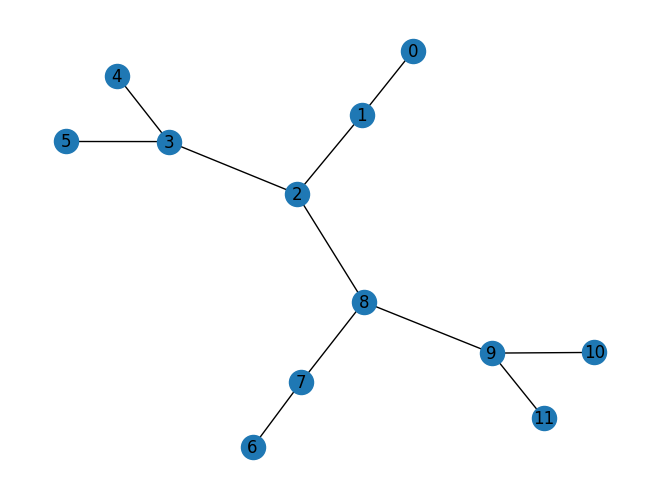

In [32]:
nx.draw(hardware_graph, with_labels=True)

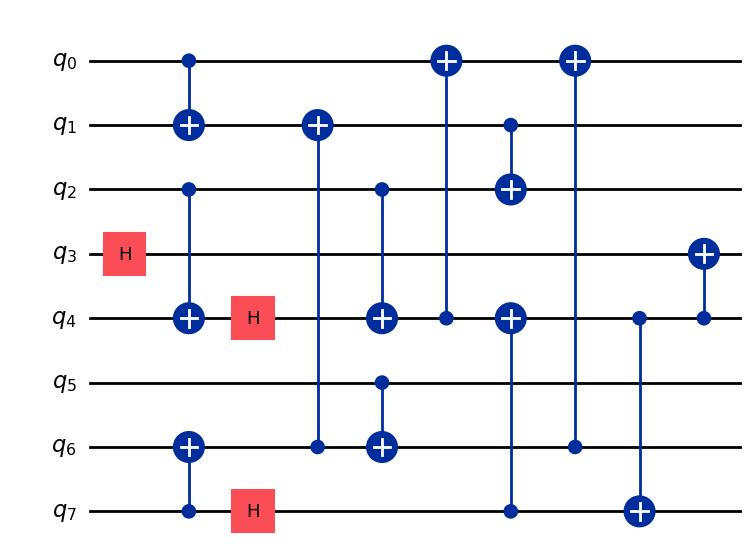

In [33]:
num_qubits = 8
circuit_depth = 15
random_circuit = generate_random_circuit(num_qubits, circuit_depth)
random_circuit.draw('mpl')

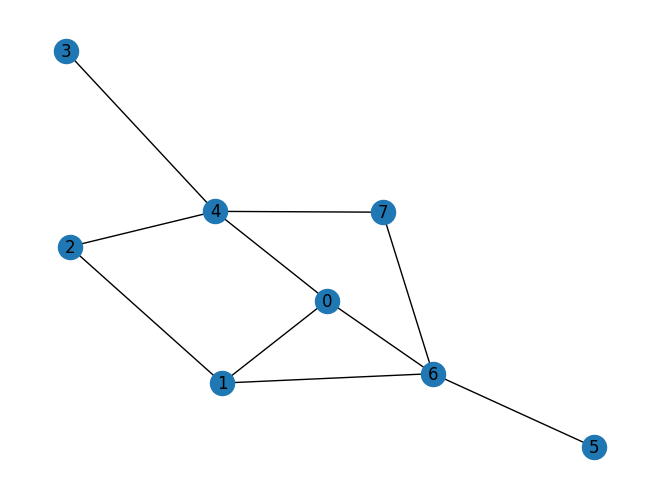

In [34]:
graph = circuit_to_graph(random_circuit, hardware_graph)
nx.draw(graph, with_labels=True)

[1, 2, 6, 9, 4]
[5, 7, 3, 0, 8]


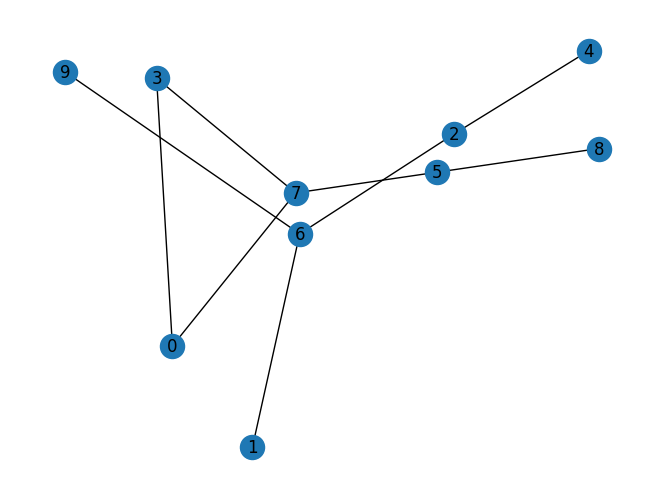

In [25]:
partitioned_graph, inter_qpu_edges = partition_graph(random_circuit, hardware_graph, method='KL')
for part in partitioned_graph:
    nx.draw(part, with_labels=True)
    print(part.nodes)

In [20]:
inter_qpu_edges

[(0, 4), (1, 2), (3, 2), (3, 4), (6, 5), (6, 7), (9, 5), (9, 8)]

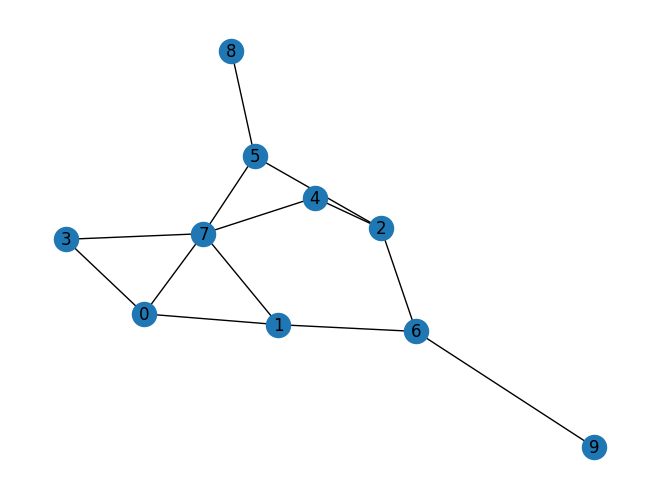

In [21]:
graph = circuit_to_graph(random_circuit, hardware_graph)
nx.draw(graph, with_labels=True)

# Adjacency sandbox

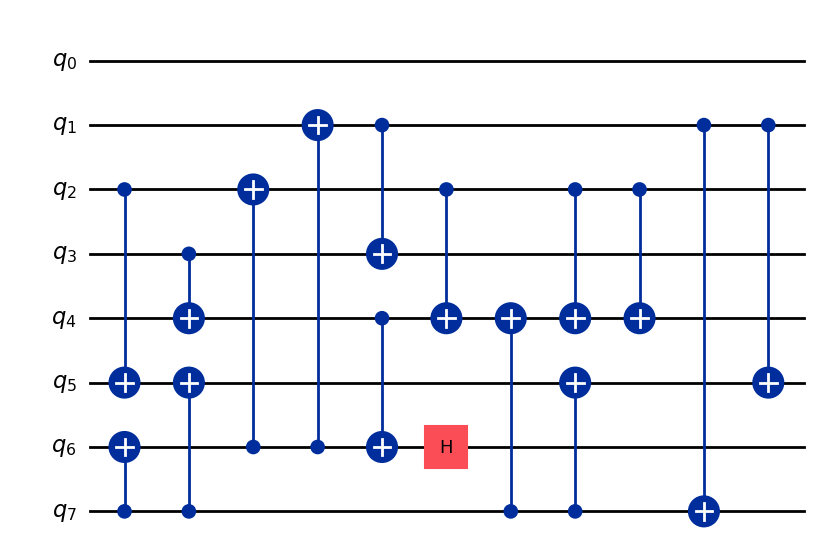

In [3]:
num_qubit = 8
circuit_depth = 16
qc = generate_random_circuit(num_qubit, circuit_depth)
qc.draw('mpl')

In [4]:
graph, adj_matrix, qubit_indices = circuit_to_graph_and_matrix(qc)

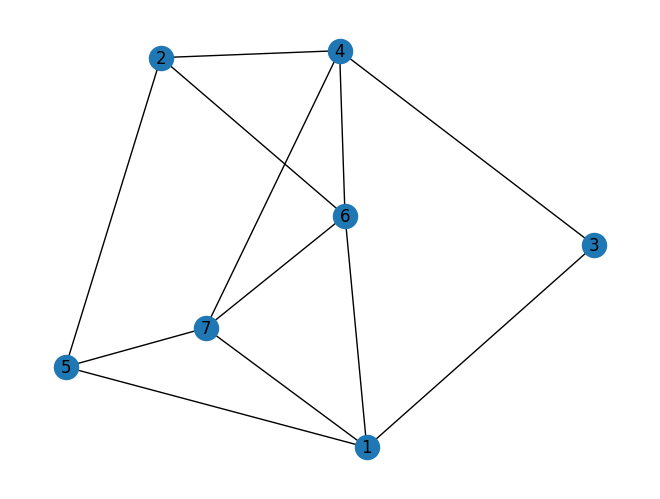

In [5]:
nx.draw(graph, with_labels=True)

In [24]:
adj_matrix

array([[0, 1, 0, 1, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 1],
       [1, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 2, 0],
       [1, 1, 1, 0, 1, 2, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0]])

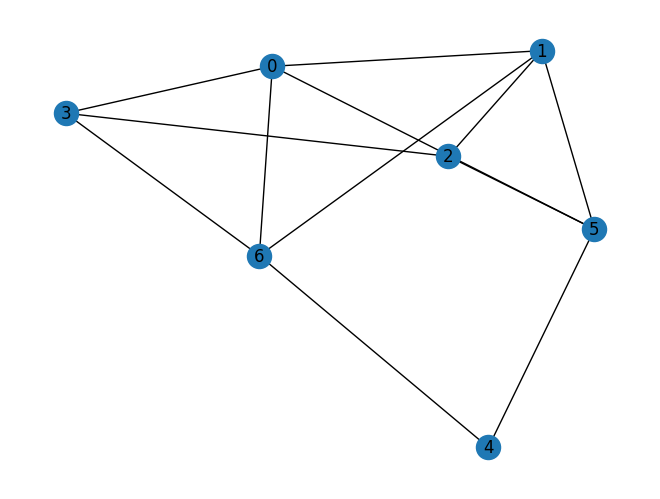

In [6]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

# Draw the graph
nx.draw(G, with_labels=True)